In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('isAvailable: ', device)

isAvailable:  cuda


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 128
num_epochs = 10
learning_rate = 0.001

In [ ]:
# Define the transformations for the training dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Define the transformations for the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Load the CIFAR-10 dataset with the defined transformations
train_dataset = torchvision.datasets.CIFAR10(root='path/to/data', train=True,
                                       download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='path/to/data', train=False,
                                       download=True, transform=transform_test)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 43286857.22it/s]


Extracting path/to/data/cifar-10-python.tar.gz to path/to/data
Files already downloaded and verified


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Input: 3 channels, Output: 64 channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Input: 64 channels, Output: 128 channels
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Input: 128 channels, Output: 256 channels
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Input: 256 channels, Output: 512 channels

        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # input size for the fully connected layer
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 10)  # Output layer for 10 classes

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))  # Conv1
        x = self.pool(F.relu(self.conv2(x)))  # Conv2
        x = self.pool(F.relu(self.conv3(x)))  # Conv3
        x = self.pool(F.relu(self.conv4(x)))  # Conv4

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler for learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    for i, (images, labels) in enumerate(train_loader):  # Iterate over batches of data
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()  # Zero the gradients for the optimizer
        outputs = model(images)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss for averaging
        _, predicted = outputs.max(1)  # Get predicted class indices
        total += labels.size(0)  # Update total samples processed
        correct += predicted.eq(labels).sum().item()  # Count correct predictions

    print(f'Train Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100. * correct / total:.2f}%')


In [ ]:
import matplotlib.pyplot as plt

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()  # Accumulate validation loss
            _, predicted = outputs.max(1)  # Get predicted class indices
            total += labels.size(0)  # Update total samples processed
            correct += predicted.eq(labels).sum().item()  # Count correct predictions

    val_accuracy = 100. * correct / total
    return val_loss / len(test_loader), val_accuracy  # Return validation loss and accuracy


# Training function
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # After training an epoch, calculate accuracy and loss
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation after each epoch
        val_loss, val_accuracy = validate(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Step the learning rate scheduler
        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% '
              f'- Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs
)



Epoch [1/10] - Train Loss: 1.6023, Train Accuracy: 40.62% - Val Loss: 1.3400, Val Accuracy: 51.49%
Epoch [2/10] - Train Loss: 1.1607, Train Accuracy: 58.47% - Val Loss: 1.0689, Val Accuracy: 62.22%
Epoch [3/10] - Train Loss: 0.9598, Train Accuracy: 66.19% - Val Loss: 0.8543, Val Accuracy: 69.66%
Epoch [4/10] - Train Loss: 0.8348, Train Accuracy: 70.48% - Val Loss: 0.7645, Val Accuracy: 73.54%
Epoch [5/10] - Train Loss: 0.7603, Train Accuracy: 73.32% - Val Loss: 0.7607, Val Accuracy: 73.86%
Epoch [6/10] - Train Loss: 0.6986, Train Accuracy: 75.53% - Val Loss: 0.6781, Val Accuracy: 76.30%
Epoch [7/10] - Train Loss: 0.6523, Train Accuracy: 77.27% - Val Loss: 0.6429, Val Accuracy: 77.71%
Epoch [8/10] - Train Loss: 0.6188, Train Accuracy: 78.35% - Val Loss: 0.6369, Val Accuracy: 78.39%
Epoch [9/10] - Train Loss: 0.5843, Train Accuracy: 79.42% - Val Loss: 0.6163, Val Accuracy: 78.92%
Epoch [10/10] - Train Loss: 0.5563, Train Accuracy: 80.48% - Val Loss: 0.5977, Val Accuracy: 79.37%


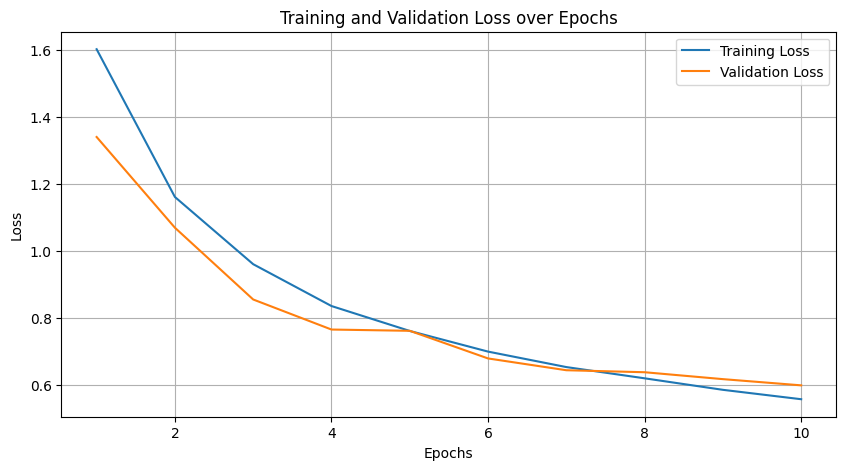

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation losses
def plot_losses(train_losses, val_losses, num_epochs):
    epochs = range(1, num_epochs + 1)  # Epoch numbers

    plt.figure(figsize=(10, 5))  # Set figure size
    plt.plot(epochs, train_losses, label='Training Loss')  # Plot training loss
    plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation loss
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()  # Show legend
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot

# Call the plotting function
plot_losses(train_losses, val_losses, num_epochs)


In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return avg_test_loss, accuracy  # Return test loss and accuracy for logging or plotting

In [ ]:
test(model,test_loader, criterion, device)

Test Loss: 0.5977, Accuracy: 79.37%


(0.5977172463000575, 79.37)